# **Evaluate Natural Language Generation (NLG) Using LLMs**

### Overview
This is a basic demonstration that serves as an introduction to naural language generation (NLG) evaluation using Azure PromptFlow. Ensuing notebook demonstrations will build on the simple concepts in this notebook.  
  
In this demonstration, you will evaluate the output of a simple chat LLM using an LLM. You will evaluate chat outputs for the following metrics:
1. **Fluency** - Measures how grammatically and linguistically correct the model's predicted answer is.
2. **Coherence** - Measures the quality of all sentences in a model's predicted answer and how they fit together naturally.
3. **Relevance** - Measures how relevant the model's predicted answers are to the questions asked.

After utilizing Azure PromptFlow to generate and evaluate chat responses, this notebook will take a deeper look at the results.

 **_Go Deeper_**  
 For more details on the research behind the demonstrated concepts check out the links below.  
- [Leveraging Large Language Models for NLG Evaluation](https://arxiv.org/pdf/2401.07103.pdf)
- [G-EVAL: NLG Evaluation using Gpt-4 with Better Human Alignment](https://ar5iv.labs.arxiv.org/html/2303.16634)
  
**_Prerequisites_**  
  
Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)

## 1. Upload Sample Input Data

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import os

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time

local_path = "../data/inputs/simple_chat_sample_inputs.csv"
# set the version number of the data asset to the current UTC time
v1 = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())


my_data = Data(
    name="simple-chat-sample-inputs",
    version=v1,
    description="Sample inputs for simple chat flow",
    path=local_path,
    type=AssetTypes.URI_FILE,
)

# create data asset
ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

## 2. Run Simple Chat & GPT Evaluation PromptFlow Jobs
In this section you will run a [simple chat prompt flow](../src/promptflow/sample_chat_flows/simple_chat) against a small [sample dataset](../data/inputs/simple_chat_sample_inputs.csv)  

Then, as part of the same job, you will evaluate the GPT metrics above using an [evaluation PromptFlow](../src/promptflow/evaluation_flows/gpt_eval/)

Both the simple chat and the evaluation utilize the AOAI connection established during setup and cooresponding GPT4 deployment

##### **IMPORTANT**: _Please take a moment to analyze in depth the Simple Chat, Evaluation Flow, and the sample dataset linked above_
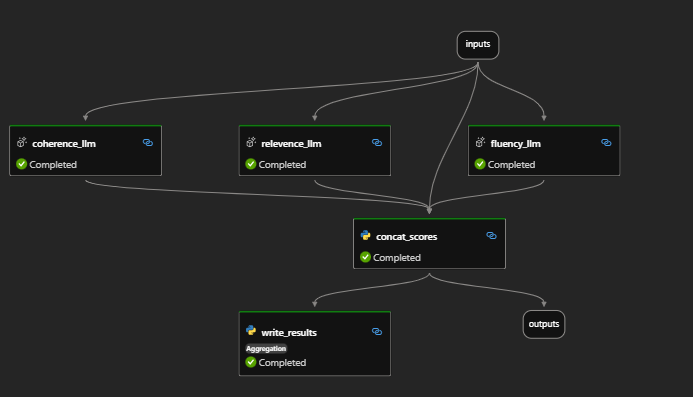

In [ ]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
simple_chat_flow = "../src/promptflow/sample_chat_flows/simple_chat" # set the flow directory
eval_flow = "../src/promptflow/evaluation_flows/gpt_eval" # set flow directory
data = "../data/inputs/simple_chat_sample_inputs.csv" # set the data file

# Run chat flow to generate chat results
chat_run = pf.run(
    flow=simple_chat_flow,
    data=data,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "input": "${data.input}",
    }
)

# Run evaluation flow to evaluate chat results
eval_run = pf.run(
    flow=eval_flow,
    data=data,
    run=chat_run,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "question": "${data.input}",
      "response": "${run.outputs.output}",
    }
)


Helpful Documentation:  
[Run and Evaluate a PromptFlow](https://microsoft.github.io/promptflow/how-to-guides/run-and-evaluate-a-flow/index.html)  
[PFClient Documentation](https://microsoft.github.io/promptflow/reference/python-library-reference/promptflow.html)

## 3.  View Results  
To view outputs in detail analyze the [output data](../data/outputs/gpt_eval_results.json) directly

In [ ]:
import pandas as pd

output_data = "../data/outputs/gpt_eval_results.json"

output_df = pd.read_json(output_data)
display(output_df)

## 4. Next Steps
How do I know my LLM based evaluation is effective?? Check out [Notebook #2 - GPT Eval Benchmark](./2_gpt_eval_benchmark.ipynb)!